# Курс по машинному обучению,   ВМК МГУ
## Градиентный бустинг деревьев

### Важно! О формате сдачи

* **Практически все выделенные задания из ноутбука оцениваются по системе <font color='red'>кросс-рецензирования</font>. Задания, в котором надо реализовать свой код и послать в систему, выделены здесь и в pdf отдельно**
* **В этом ноутбуке есть задание на ML-решение**
* **При решении ноутбука используйте данный шаблон. Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно**
* **Везде, где в формулровке задания есть какой-либо вопрос (или просьба вывода), необходимо прописать ответ в ячейку (код или markdown).**
* **Наличие кода решения обязательно. Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.**

**А также..**

Если в ячейке написана фраза "Вывод"/"Ответ на вопрос" итд, то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если в ячейке написано "Your code here", то ожидается ответ в виде кода (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если есть и ячейка с фразой "Вывод", и ячейка с фразой "Your code here", то в ответе ожидается и код, и текст)

__В этом задании вы..:__

- Познакомитесь с несколькими новыми библиотеками машинного обучения
- Сравните между собой разные реализации градиентных бустингов
- Примените все полученные знания для получения лучшего скора на датасете фильмов




## Введение

Привет, ребятушки!

Сегодня мы с вами будем решать очень важную задачу, а именно оценивать цену поддержанных автомобилей в ряде стран. Делать мы это будем с помощью различных методов градиентного бустинга. Мы с вами узнаем, что в мире существует не только sklearn, и что существуют библиотеки, облегчающие нам задачу поиска оптимальных параметров для моделей.

**Внимание! Во всех заданиях в качестве целевой метрики используется MAE (средняя абсолютная ошибка).** Значение MAE вычисляется как

$$
  MAE = \sum_{i = 1}^N\dfrac{|a(x_i) - y_i|}{N},
$$

где $N$ - число объектов в тестовой выборке, $x_i$ - вектор признаков i-го объекта, $a(x_i)$ - предсказание на i-ом объекте, $y_i$ - значение целевого признака на i-м объекте.

## Установка дополнительных библиотек.

В этом задании нам понадобятся три бибиотеки, которыми вы ранее не пользовались в этом курсе, а именно:

**XGBoost**: Документация [здесь](https://xgboost.readthedocs.io/en/stable/).<br />
**LightGBM**: Документация [здесь](https://lightgbm.readthedocs.io/en/latest/index.html). Также дополнительно про установку [тут](https://pypi.org/project/lightgbm/).<br />
**Catboost**: Документация [здесь](https://catboost.ai/en/docs/). Можно найти также некоторую информацию на русском [тут](https://habr.com/ru/company/otus/blog/527554/).<br />
**HyperOpt**: Документация [здесь](http://hyperopt.github.io/hyperopt/). <br />

Все библиотеки легко ставятся через pip (либо альтернативные установщики вроде conda).


## Как правильно перебирать параметры

В этом ноутбуке мы будем несколько раз заниматься поиском оптимальных параметров для градиентного бустинга, перебирая задания по заданной сетке. В этом задании от Вас не будет требоваться найти самые лучшие параметры, но всё равно важно правильно составлять сетку для перебора. Для этого нужно понимать суть параметров и их смысл.



**learning_rate** -- темп обучения нашего метода. Для этого метода сетка перебора должна быть логарифмической, т.е. перебирать порядковые значения (к примеру, [1e-3, 1e-2, 1e-1, 1]). В большинстве случаев достаточно перебрать значения от 1e-5 до 1.<br />
**max_depth** -- максимальная глубина деревьев в ансамбле. Вообще говоря, эта величина зависит от числа признаков, но обычно лучше растить небольшие деревья. К примеру, библиотека CatBoost, которую мы будем исследовать сегодня, рекомендует перебирать значения до 10 (и уточняется, что обычно оптимальная глубина лежит от 6 до 10).<br />
**n_estimators** -- количество деревьев в ансамбле. Обычно стоит перебирать с каким-то крупным шагом (можно по логарифмической сетке). Здесь важно найти баланс между производительностью, временем обучения и качеством. Обычно нескольких тысяч деревьев бывает достаточно.<br />

Учтите, что в реальных задачах необходимо следить за тем, что оптимальные значения параметров не попадают на границы интервалов, т.е. что вы нашли хотя бы локальный минимум. Если Вы перебрали значения параметра от 1 до 10 и оказалось, что 10 - оптимальное значение, значит следует перебрать и бОльшие числа, чтобы убедиться, что качество не улучшается дальше (или по крайней мере убедиться, что рост качества сильно замедляется и на сильное улучшения рассчитывать не стоит.


## Подготовка датасета

Все библиотеки, используемые сегодня, мы будем проверять на одних и тех же параметрах: n_estimators=1000, max_depth=5, learning_rate=0.1. Таким образом мы устанавливаем, соответственно, число деревьев в ансамбле равным 1000, ограничиваем максимальную глубину деревьев 5 и устанавливаем темп обучения равным 0.1. Создадим сразу словарь, чтобы передавать эти параметры создаваемым регрессорам (если вдруг не знали, словарь можно передавать как параметры, поставив перед ним **).

Эти параметры мы вынесем в отдельную переменную `test_parameters`.

<span style="color:red">Загрузите датасет, с которым мы будем работать. Его можно найти на платформе cv-gml.ru, в задании `Град. бустинг (ML)`, по ссылке `Дополнительные файлы для решения`. Если Вы решите сохранить этот файл не рядом с ноутбуком, Вы можете исправить путь к этому файлу во второй ячейке ноутбука (в строке с `read_csv`).</span>

При желании можно почитать про этот датасет на платформе kaggle: [ссылка на данные](https://www.kaggle.com/bushnag/cars-in-the-middle-east?select=dataframe_YesIndex_YesHeader_C.csv). <span style="color:red"> Не скачивайте датасет из kaggle для выполнения ноутбука, поскольку его могут изменить.</span> Нас интересует файл dataframe_YesIndex_YesHeader_C.csv, поскольку он уже хорошо предобработан (хотя, конечно, датасаентисты должны сами уметь это делать, но ладно).
Давайте попробуем загрузить датасет в память и посмотреть, как он выглядит.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt.fmin import fmin
from hyperopt.pyll import scope

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt

import pandas as pd

import numpy as np

import time


In [2]:
test_parameters = {"n_estimators": 1000, "max_depth": 5, "learning_rate":0.1}

df = pd.read_csv('dataframe_YesIndex_YesHeader_C.csv', index_col=0)
df.head()

,Engine Capacity,Cylinders,Drive Type,Fuel Tank Capacity,Fuel Economy,Fuel Type,Horsepower,Torque,Transmission,Top Speed,...,Acceleration,Length,Width,Height,Wheelbase,Trunk Capacity,name,price,currency,Country
0,1.2,3,0,42.0,4.9,0,76,100.0,0,170,...,14.0,4.245,1.670,1.515,2.550,450.0,Mitsubishi Attrage 2021 1.2 GLX (Base),34099.0,0,0
1,1.2,3,0,42.0,4.9,0,76,100.0,0,170,...,14.0,4.245,1.670,1.515,2.550,450.0,Mitsubishi Attrage 2021 1.2 GLX (Base),34099.0,0,0
2,1.4,4,0,45.0,6.3,0,75,118.0,1,156,...,16.0,3.864,1.716,1.721,2.513,2800.0,Fiat Fiorino 2021 1.4L Standard,41250.0,0,0
3,1.6,4,0,50.0,6.4,0,102,145.0,0,180,...,11.0,4.354,1.994,1.529,2.635,510.0,Renault Symbol 2021 1.6L PE,44930.0,0,0
4,1.5,4,0,48.0,5.8,0,112,150.0,0,170,...,10.9,4.314,1.809,1.624,2.585,448.0,MG ZS 2021 1.5L STD,57787.0,0,0


### Задание 0 (без проверки, 0 баллов)

Посмотрите на цены автомобилей. Попробуйте понять, написаны они в одной валюте или нет. Если нет -- будут ли у нас серьезные проблемы при использовании деревьев? Стоит ли нам что-то сделать для того, чтобы нивелировать эту проблему?


В глаза бросаются две проблемы: у нас имеется информация о производителе автомобиля, скрытая в текстовой переменной модели автомобиля (нет отдельного признака). Также имеются некоторые категориальные переменные. Со всем этим безобразием надо что-то сделать.

### **Задание 1 (кросс-проверка, 3 балла)**
**Данные**: датасет со стоимостью поддержанных автомобилей  
**Цели**: В данном задании следует выполнить следующие пункты (выполнять можно в любом порядке)
1. Изучить датасет, проверить наличие пропусков. При необходимости заменить их на среднее значение признака.
3. Добавить столбец brand с информацией о производителе автомобиля (для простоты можно взять первое слово в названии модели)
4. Решить, какие признаки Вы хотите сделать категориальными. Конвертировать выбранные категориальные столбцы в тип category. 
5. Создать датасет А с категориальными признаками в виде категорий. Для этого необходимо создать вектор целевых значений (столбец цен автомобилей) и матрицу признаков с категориальными переменными в виде категорий (получается путем удаления только целевой переменной из матрицы с данными). Дополнительно стоит создать список с названиями и индексами столбцов категориальных переменных (поможет в будущем).
6. Создать датасет B без категориальных признаков. Для этого необходимо создать вектор целевых значений (столбец цен автомобилей) и удалить из матрицы признаков столбец с целевыми переменными, а также все категориальные переменные.
8. Создать датасет C с категориальными признаками в виде one-hot encoding. Для этого необходимо создать вектор целевых значений (столбец цен автомобилей), удалить из матрицы признаков столбец с целевыми переменными и все категориальными переменные, а затем добавить новые признаки, соответствующие one-hot encoding категориальных переменных (здесь вам поможет функция `pd.get_dummies`).
9. Разбить датасеты на тренировочное и тестовое множества, используя `train_test_split(X, y, test_size=0.25, random_state=0)` (зафиксировав random_seed мы получим одинаковое разбиение на обучение/тест для всех трёх выборок).

In [3]:
datasets = {'A' : None, 'B': None, 'C': None}

print(f"Number of missing values in dataset: {df.isnull().sum().sum()}")

df["brand"] = df.name.apply(lambda name: name.split()[0])
df = df.drop("name", axis=1)

categorical_features = ["Drive Type", "Fuel Type", "Transmission", "currency", "Country", "brand"]
df[categorical_features] = df[categorical_features].astype("category")

X_A = df.drop("price", axis=1)
sidx = np.argsort(X_A.columns)
categorical_indices = sidx[np.searchsorted(X_A.columns, categorical_features, sorter=sidx)]

X_B = X_A.drop(categorical_features, axis=1)

X_C = pd.concat([X_B, pd.get_dummies(df[categorical_features])], axis=1)

y = df.price

datasets['A'] = train_test_split(X_A, y, test_size=0.25, random_state=0)
datasets['B'] = train_test_split(X_B, y, test_size=0.25, random_state=0)
datasets['C'] = train_test_split(X_C, y, test_size=0.25, random_state=0)

AX_train, AX_test, Ay_train, Ay_test = datasets['A']
BX_train, BX_test, By_train, By_test = datasets['B']
CX_train, CX_test, Cy_train, Cy_test = datasets['C']

Number of missing values in dataset: 0


Итак, кажется, что у нас всё готово для того, чтобы начать искать ответы на волнующие нас вопросы. Начнем со столь любимой нами библиотеки, а именно...

## Градиентный бустинг со sklearn

Естественно, в sklearn имеется реализация градиентного бустинга, которая хранится в sklearn.ensemble.GradientBoostingRegressor. Преимущественно данным классом пользуются в учебных заданиях, поскольку в реальных задачах предпочтение отдаётся другим библиотекам. Давайте попробуем понять, заслуженно ли градиентный бустинг в sklearn не пользуется популярностью.

FYI: в sklearn имеется также реализация GradientBoostingClassifier для задач классификации, но пользоваться им мы сегодня не будем.

GradientBoostingRegressor из коробки не умеет работать с категориальными признаками. Мы к этому уже подготовились, закодировав наши признаки.

### **Задание 2 (кросс-проверка, 2 балла)**:

**Данные**: датасет со стоимостью поддержанных автомобилей    
**Метрика**: MAE    
**Цели**: В данном задании следует выполнить следующие пункты:    
1. Обучить sklearn.ensemble.GradientBoostingRegressor на датасетах B и C, используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1 (наши `test_parameters`). Замерьте время обучения, получите предсказания данных моделей на тестовом множестве.
2. Обучить sklearn.ensemble.GradientBoostingRegressor на датасете B (можно и на C, если позволяют вычислительные ресурсы), используя кросс-валидацию на тренировочном множестве и подбирая значения для параметров n_estimators, learning_rate и max_depth. Для простоты можете воспользоваться GridSearchCV. При необходимости можно оптимизировать параметры по одному, а не все сразу. Выведите лучшие параметры. Получите предсказания лучшей модели (с лучшими параметрами) на тестовом множестве. Для ускорения процесса не забудьте воспользоваться n_jobs.
3. Посчитать MAE для полученных предсказаний на тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error).
5. Вывести результаты и время в таблице DataFrame.
4. Сделайте выводы. Оцените полезность категориальных переменных и поиска оптимальных параметров. Оцените время, затраченное на обучение. Попробуйте дать оценку получившемуся MAE: оно большое или маленькое?


In [4]:
df_skl = pd.DataFrame(columns=['Dataset', 'Parameters', 'Time', 'MAE'])

skl = GradientBoostingRegressor(**test_parameters)

df_skl.loc[len(df_skl)] = ["A", "default", 0, 0]

cur_time = time.time()
skl.fit(BX_train, By_train)
fit_time = time.time() - cur_time
MAE_train = mean_absolute_error(y_true=By_train, y_pred=skl.predict(BX_train))
MAE_test = mean_absolute_error(y_true=By_test, y_pred=skl.predict(BX_test))
print(f"Fit time for Sklearn with default parameters on dataset B: {fit_time}")
print(f"MAE on train for Sklearn with default parameters on dataset B: {MAE_train}")
print(f"MAE on test for Sklearn with default parameters on dataset B: {MAE_test}\n")
df_skl.loc[len(df_skl)] = ["B", "default", fit_time, MAE_test]

cur_time = time.time()
skl.fit(CX_train, Cy_train)
fit_time = time.time() - cur_time
MAE_train = mean_absolute_error(y_true=Cy_train, y_pred=skl.predict(CX_train))
MAE_test = mean_absolute_error(y_true=Cy_test, y_pred=skl.predict(CX_test))
print(f"Fit time for Sklearn with default parameters on dataset C: {fit_time}")
print(f"MAE on train for Sklearn with default parameters on dataset C: {MAE_train}")
print(f"MAE on test for Sklearn with default parameters on dataset C: {MAE_test}\n")
df_skl.loc[len(df_skl)] = ["C", "default", fit_time, MAE_test]

parameters = { "n_estimators" :  [1000, 2000, 3000]
             , "learning_rate" : [0.01, 0.1, 1]
             , "max_depth" : [3, 5, 7]
             }

skl_cv = GridSearchCV(estimator=GradientBoostingRegressor(), 
                      param_grid=parameters, 
                      scoring="neg_mean_absolute_error", 
                      cv=5, 
                      n_jobs=-1)

df_skl.loc[len(df_skl)] = ["A", "best", 0, 0]

cur_time = time.time()
skl_cv.fit(BX_train, By_train)
cv_time = time.time() - cur_time
best_MAE_train = mean_absolute_error(y_true=By_train, y_pred=skl_cv.predict(BX_train))
best_MAE_test = mean_absolute_error(y_true=By_test, y_pred=skl_cv.predict(BX_test))
print(f"Best parameters for Sklearn on dataset B:\n {skl_cv.best_params_}")
print(f"MAE on train for Sklearn with best parameters on dataset B: {best_MAE_train}")
print(f"MAE on test for Sklearn with best parameters on dataset B: {best_MAE_test}\n")
df_skl.loc[len(df_skl)] = ["B", "best", cv_time, best_MAE_test]

cur_time = time.time()
skl_cv.fit(CX_train, Cy_train)
cv_time = time.time() - cur_time
best_MAE_train = mean_absolute_error(y_true=Cy_train, y_pred=skl_cv.predict(CX_train))
best_MAE_test = mean_absolute_error(y_true=Cy_test, y_pred=skl_cv.predict(CX_test))
print(f"Best parameters for Sklearn on dataset C:\n {skl_cv.best_params_}")
print(f"MAE on train for Sklearn with best parameters on dataset C: {best_MAE_train}")
print(f"MAE on test for Sklearn with best parameters on dataset C: {best_MAE_test}")
df_skl.loc[len(df_skl)] = ["C", "best", cv_time, best_MAE_test]

df_skl

Fit time for Sklearn with default parameters on dataset B: 6.608875513076782
MAE on train for Sklearn with default parameters on dataset B: 91885.18887320266
MAE on test for Sklearn with default parameters on dataset B: 123325.31870851915

Fit time for Sklearn with default parameters on dataset C: 12.57648491859436
MAE on train for Sklearn with default parameters on dataset C: 4505.48524198978
MAE on test for Sklearn with default parameters on dataset C: 18098.37761805789

Best parameters for Sklearn on dataset B:
 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
MAE on train for Sklearn with best parameters on dataset B: 97835.79246925077
MAE on test for Sklearn with best parameters on dataset B: 121878.51610984637

Best parameters for Sklearn on dataset C:
 {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 3000}
MAE on train for Sklearn with best parameters on dataset C: 2273.2851653787216
MAE on test for Sklearn with best parameters on dataset C: 16487.87904445597


,Dataset,Parameters,Time,MAE
0,A,default,0.000000,0.000000
1,B,default,6.608876,123325.318709
2,C,default,12.576485,18098.377618
3,A,best,0.000000,0.000000
4,B,best,269.661722,121878.516110
5,C,best,547.512596,16487.879044


**Ваши выводы:** Начнем с категориальных признаков. И с начальными параметрами, и с оптимальными мы получили огромное преимущество в качестве работы моделей: разница МАЕ колоссальная. Но, важно отметить, что время обучения на датасете без категориальных признаков примерно в 2 раза больше, так же как и подбор оптимальных параметров осуществляется примерно в 2 раза дольше. Что касается необходимости поиска оптимальных параметров, то тут мнение неоднозначное. Ожидаемо (ибо начальные параметры входят в сетку), что мы получили лучшее качество моделей. Но вопрос о том, стоило ли тратить в десятки раз больше времени на общее обучение ради пару тысяч на МАЕ, открыт. Мне лично кажется, что если есть возможность улучшить работу алгоритма, то это нужно делать, если только это не приводит к абсурдному увеличению времени обучения. В данном случае, мы находимя где-то посередине, но я бы не стал применять кросс-валидацию, зная, что получу такие результаты. Итак, время обучения сравнительно невелико, зная, что бустинг в Sklearn далеко не самый оптимальный. А время поиска оптимальных параметров, как и ожидалось, солидное. Так что, стоит лишний раз задуматься, так ли сильно может увеличиться точность при наилучших параметрах. Что касается МАЕ, то на датасете В оно получилось очень большое, наш алгоритм вовсе не пригоден. На датасете С ситуация получше. Хоть и хотелось бы поточнее, но результат приемлем.

И так, sklearn предлагает нам привычный и простой способ тренировки моделей. Однако, для градиентного бустинга существует множество эвристик и трюков, помогающих улучшить результаты. И одна из библиотек, реализующая улучшенную версию бустинга, называется xgboost.

## Градиентный бустинг с XGBoost

XGBoost стала достаточно популярной библиотекой, которая позволяет добиться хороших результатов без особых усилий (во всяком случае, так гласят легенды). И у нас для вас две новости: хорошая и плохая. Хорошая – xgboost, хоть и является сторонней библиотекой, сохраняет интерфейс sklearn и даже прекрасно работает с GridSearchCV. Плохая – она тоже не умеет из коробки работать с категориальными признаками. Ну что же, давайте пощупаем это безобразие. На этот раз нас интересует класс xgboost.XGBRegressor.

Update: относительно недавно в xgboost появилась экспериментальная поддержка категориальных переменных, которая еще не добавлена в стабильную версию, поэтому ею мы пользоваться пока не будем.

### Задание 3 (кросс-проверка, 2 балла):
**Данные**: датасет со стоимостью поддержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучить xgboost.XGBRegressor на датасетах B и C, используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1 (наши `test_parameters`). Замерьте время обучения. Получите предсказания данных моделей на тестовом множестве.
2. Обучить xgboost.XGBRegressor на датасетах B и C, используя кросс-валидацию на тренировочном множестве и подбирая значения для параметров n_estimators, learning_rate и max_depth (для простоты можете воспользоваться GridSearchCV). При необходимости можно оптимизировать параметры по одному, а не все сразу. Замерьте время перебора, получите предсказания лучшей модели (с лучшими параметрами) на тестовом множестве. В этом случае устанавливать n_jobs у GridSearchCV не рекомендую, поскольку xgboost сам умеет захватывать все доступные ресурсы, и если GridSearchCV начнет их размножать, то последствия будут печальны.
3. Посчитать MAE для полученных предсказаний на тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error).
1. Выведите результаты и время в таблице DataFrame.
4. Сделайте выводы. Оцените полезность категориальных переменных и поиска оптимальных параметров. Оцените время, затраченное на обучение. Сравните результаты со sklearn.

In [5]:
df_xgb = pd.DataFrame(columns=['Dataset', 'Parameters', 'Time', 'MAE'])

xgb = XGBRegressor(**test_parameters)

df_xgb.loc[len(df_xgb)] = ["A", "default", 0, 0]

cur_time = time.time()
xgb.fit(BX_train, By_train)
fit_time = time.time() - cur_time
MAE_train = mean_absolute_error(y_true=By_train, y_pred=xgb.predict(BX_train))
MAE_test = mean_absolute_error(y_true=By_test, y_pred=xgb.predict(BX_test))
print(f"Fit time for XGBoost with default parameters on dataset B: {fit_time}")
print(f"MAE on train for XGBoost with default parameters on dataset B: {MAE_train}")
print(f"MAE on test for XGBoost with default parameters on dataset B: {MAE_test}\n")
df_xgb.loc[len(df_xgb)] = ["B", "default", fit_time, MAE_test]

cur_time = time.time()
xgb.fit(CX_train, Cy_train)
fit_time = time.time() - cur_time
MAE_train = mean_absolute_error(y_true=Cy_train, y_pred=xgb.predict(CX_train))
MAE_test = mean_absolute_error(y_true=Cy_test, y_pred=xgb.predict(CX_test))
print(f"Fit time for XGBoost with default parameters on dataset C: {fit_time}")
print(f"MAE on train for XGBoost with default parameters on dataset C: {MAE_train}")
print(f"MAE on test for XGBoost with default parameters on dataset C: {MAE_test}\n")
df_xgb.loc[len(df_xgb)] = ["C", "default", fit_time, MAE_test]

parameters = { "n_estimators" :  [1000, 2000, 3000]
             , "learning_rate" : [0.01, 0.1, 1]
             , "max_depth" : [3, 5, 7]
             }

xgb_cv = GridSearchCV(estimator=XGBRegressor(), param_grid=parameters, scoring="neg_mean_absolute_error", cv=5)

df_xgb.loc[len(df_xgb)] = ["A", "best", 0, 0]

cur_time = time.time()
xgb_cv.fit(BX_train, By_train)
cv_time = time.time() - cur_time
best_MAE_train = mean_absolute_error(y_true=By_train, y_pred=xgb_cv.predict(BX_train))
best_MAE_test = mean_absolute_error(y_true=By_test, y_pred=xgb_cv.predict(BX_test))
print(f"Best parameters for XGBoost on dataset B:\n {xgb_cv.best_params_}")
print(f"MAE on train for XGBoost with best parameters on dataset B: {best_MAE_train}")
print(f"MAE on test for XGBoost with best parameters on dataset B: {best_MAE_test}\n")
df_xgb.loc[len(df_xgb)] = ["B", "best", cv_time, best_MAE_test]

cur_time = time.time()
xgb_cv.fit(CX_train, Cy_train)
cv_time = time.time() - cur_time
best_MAE_train = mean_absolute_error(y_true=Cy_train, y_pred=xgb_cv.predict(CX_train))
best_MAE_test = mean_absolute_error(y_true=Cy_test, y_pred=xgb_cv.predict(CX_test))
print(f"Best parameters for XGBoost on dataset C:\n {xgb_cv.best_params_}")
print(f"MAE on train for XGBoost with best parameters on dataset C: {best_MAE_train}")
print(f"MAE on test for XGBoost with best parameters on dataset C: {best_MAE_test}")
df_xgb.loc[len(df_xgb)] = ["C", "best", cv_time, best_MAE_test]

df_xgb


Fit time for XGBoost with default parameters on dataset B: 1.2851786613464355
MAE on train for XGBoost with default parameters on dataset B: 92312.89114247818
MAE on test for XGBoost with default parameters on dataset B: 123194.88893186334

Fit time for XGBoost with default parameters on dataset C: 2.499177932739258
MAE on train for XGBoost with default parameters on dataset C: 5601.3844222782645
MAE on test for XGBoost with default parameters on dataset C: 18453.964720307737

Best parameters for XGBoost on dataset B:
 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
MAE on train for XGBoost with best parameters on dataset B: 98651.2223315501
MAE on test for XGBoost with best parameters on dataset B: 121518.36769965991

Best parameters for XGBoost on dataset C:
 {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 3000}
MAE on train for XGBoost with best parameters on dataset C: 2281.649381653189
MAE on test for XGBoost with best parameters on dataset C: 16404.55190922252

,Dataset,Parameters,Time,MAE
0,A,default,0.000000,0.000000
1,B,default,1.285179,123194.888932
2,C,default,2.499178,18453.964720
3,A,best,0.000000,0.000000
4,B,best,225.387073,121518.367700
5,C,best,522.965629,16404.551909


**Ваши выводы:** С категориальными признаками с начальными параметрами, и с оптимальными мы получили огромное преимущество в качестве работы моделей: разница МАЕ колоссальная. Но, важно отметить, что время обучения на датасете без категориальных признаков примерно в 2 раза больше, так же как и подбор оптимальных параметров осуществляется примерно в 2 раза дольше. Что касается необходимости поиска оптимальных параметров, то тут мнение неоднозначное. Ожидаемо (ибо начальные параметры входят в сетку), что мы получили лучшее качество моделей. Но вопрос о том, стоило ли тратить в десятки раз больше времени на общее обучение ради пару тысяч на МАЕ, открыт. Мне лично кажется, что если есть возможность улучшить работу алгоритма, то это нужно делать, если только это не приводит к абсурдному увеличению времени обучения. В данном случае, мы находимя где-то посередине, но я бы не стал применять кросс-валидацию, зная, что получу такие результаты. Итак, время обучения очень даже невелико: модель обучается быстро. А время поиска оптимальных параметров, как и ожидалось, солидное. Так что, стоит лишний раз задуматься, так ли сильно может увеличиться точность при наилучших параметрах. Сравнивая полученные результаты с работой Sklearn, можно сделать вывод, что МАЕ не отличается вовсе (очень-очень несущественно), поэтому следует обратить внимание на время обучения и поиска оптимальных параметров. При обучении мы имеем очень хорошее преимущество XGBoost (примерно в 6 раз быстрее и на В, и на С) по сравнению с Sklearn. Разница во времени кросс-валидации тоже на стороне XGBoost, но она уже не настолько велика, как просто при обучении с начальными параметрами. Но все же, в итоге, имеем, что XGBoost продемонстрировал существенно лучшие результаты, хотя качество работы моделей почти не отличается.

Таким вот несложным образом нам удалось воспользоваться еще одной библиотекой. Давайте перейдем к третьей библиотеке, которую мы сегодня изучим, и называется она lightgbm.

## Градиентный бустинг в lightgbm

Про Lightgbm легенды гласят, что она очень быстрая и легкая: что самый большой датасет она без проблем переварит за относительно небольшое время. А еще её разрабатывали не хухры кто, а сами мелкомягкие, так что попробовать её определённо стоит. На этот раз у нас вновь две новости, две хороших и две плохих. Первая хорошая — lightgbm тоже работает с GridSearchCV. Вторая хорошая — lightgbm умеет из коробки работать с категориальными признаками! Плохая — делает она это немного нетривиально (не зря я просил вас запомнить категориальные переменные!). Вторая плохая — да, нам придётся этим пользоваться.

Внимание! LightGBM может писать сотню радостных сообщений о том, что он увидел ваши categorical_feature и использует их. При желании можете заглушать эти оповещения, ибо в случае перебора параметров их становится слишком много. (заклинание для заглушения: `warnings.filterwarnings("ignore")`)

### Задание 4 (кросс-проверка, 3 балла):
**Данные**: датасет со стоимостью поддержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. В случае датасета, сохраненном в numpy, lightgbm требует, чтобы категории были закодированы целыми числами от 0 до числа признаков(e.g. ['a', 'b', 'a'] -> [0, 1, 0]). Сделайте это для датасета A. Если вы используете pandas, то для датасета A достаточно установить соответствующие столбцы типа "категория", тогда categorical_feature='auto' сам всё подхватит.
2. Обучить lightgbm.LGBMRegressor на датасетах A, B и C, используя параметры используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1. В случае датасета A, передайте в функцию fit индексы/имена категориальных признаков. Замерьте время обучения, получите предсказания данных моделей на тестовом множестве.
3. Обучить lightgbm.LGBMRegressor на датасетах A, B и C, используя кросс-валидацию на тренировочном множестве и подбирая значения для параметров n_estimators, learning_rate и max_depth (для простоты можете воспользоваться GridSearchCV). Замерьте время, потраченное на поиск оптимальных параметров(вновь не советую использовать n_jobs). Замерьте время перебора, получите предсказания лучшей модели (с лучшими параметрами) на тестовом множестве.
4. Посчитать MAE для полученных предсказаний на тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error). Сделайте выводы и полезности использования категориальных переменных и поиска оптимальных параметров.
5. Вывести результаты и время в таблице DataFrame.

In [6]:
df_lgbm = pd.DataFrame(columns=['Dataset', 'Parameters', 'Time', 'MAE'])

lgbm = LGBMRegressor(**test_parameters)

cur_time = time.time()
lgbm.fit(AX_train, Ay_train)
fit_time = time.time() - cur_time
MAE_train = mean_absolute_error(y_true=Ay_train, y_pred=lgbm.predict(AX_train))
MAE_test = mean_absolute_error(y_true=Ay_test, y_pred=lgbm.predict(AX_test))
print(f"Fit time for LightGBM with default parameters on dataset A: {fit_time}")
print(f"MAE on train for LightGBM with default parameters on dataset A: {MAE_train}")
print(f"MAE on test for LightGBM with default parameters on dataset A: {MAE_test}\n")
df_lgbm.loc[len(df_lgbm)] = ["A", "default", fit_time, MAE_test]

cur_time = time.time()
lgbm.fit(BX_train, By_train)
fit_time = time.time() - cur_time
MAE_train = mean_absolute_error(y_true=By_train, y_pred=lgbm.predict(BX_train))
MAE_test = mean_absolute_error(y_true=By_test, y_pred=lgbm.predict(BX_test))
print(f"Fit time for LightGBM with default parameters on dataset B: {fit_time}")
print(f"MAE on train for LightGBM with default parameters on dataset B: {MAE_train}")
print(f"MAE on test for LightGBM with default parameters on dataset B: {MAE_test}\n")
df_lgbm.loc[len(df_lgbm)] = ["B", "default", fit_time, MAE_test]

cur_time = time.time()
lgbm.fit(CX_train, Cy_train)
fit_time = time.time() - cur_time
MAE_train = mean_absolute_error(y_true=Cy_train, y_pred=lgbm.predict(CX_train))
MAE_test = mean_absolute_error(y_true=Cy_test, y_pred=lgbm.predict(CX_test))
print(f"Fit time for LightGBM with default parameters on dataset C: {fit_time}")
print(f"MAE on train for LightGBM with default parameters on dataset C: {MAE_train}")
print(f"MAE on test for LightGBM with default parameters on dataset C: {MAE_test}\n")
df_lgbm.loc[len(df_lgbm)] = ["C", "default", fit_time, MAE_test]

parameters = { "n_estimators" :  [1000, 3000, 5000]
             , "learning_rate" : [0.01, 0.1, 1]
             , "max_depth" : [3, 5, 7]
             }

lgbm_cv = GridSearchCV(estimator=LGBMRegressor(), param_grid=parameters, scoring="neg_mean_absolute_error", cv=5)

cur_time = time.time()
lgbm_cv.fit(AX_train, Ay_train)
cv_time = time.time() - cur_time
best_MAE_train = mean_absolute_error(y_true=Ay_train, y_pred=lgbm_cv.predict(AX_train))
best_MAE_test = mean_absolute_error(y_true=Ay_test, y_pred=lgbm_cv.predict(AX_test))
print(f"Best parameters for LightGBM on dataset A:\n {lgbm_cv.best_params_}")
print(f"MAE on train for LightGBM with best parameters on dataset A: {best_MAE_train}")
print(f"MAE on test for LightGBM with best parameters on dataset A: {best_MAE_test}\n")
df_lgbm.loc[len(df_lgbm)] = ["A", "best", cv_time, best_MAE_test]

cur_time = time.time()
lgbm_cv.fit(BX_train, By_train)
cv_time = time.time() - cur_time
best_MAE_train = mean_absolute_error(y_true=By_train, y_pred=lgbm_cv.predict(BX_train))
best_MAE_test = mean_absolute_error(y_true=By_test, y_pred=lgbm_cv.predict(BX_test))
print(f"Best parameters for LightGBM on dataset B:\n {lgbm_cv.best_params_}")
print(f"MAE on train for LightGBM with best parameters on dataset B: {best_MAE_train}")
print(f"MAE on test for LightGBM with best parameters on dataset B: {best_MAE_test}\n")
df_lgbm.loc[len(df_lgbm)] = ["B", "best", cv_time, best_MAE_test]

cur_time = time.time()
lgbm_cv.fit(CX_train, Cy_train)
cv_time = time.time() - cur_time
best_MAE_train = mean_absolute_error(y_true=Cy_train, y_pred=lgbm_cv.predict(CX_train))
best_MAE_test = mean_absolute_error(y_true=Cy_test, y_pred=lgbm_cv.predict(CX_test))
print(f"Best parameters for LightGBM on dataset C:\n {lgbm_cv.best_params_}")
print(f"MAE on train for LightGBM with best parameters on dataset C: {best_MAE_train}")
print(f"MAE on test for LightGBM with best parameters on dataset C: {best_MAE_test}")
df_lgbm.loc[len(df_lgbm)] = ["C", "best", cv_time, best_MAE_test]

df_lgbm


Fit time for LightGBM with default parameters on dataset A: 0.2485058307647705
MAE on train for LightGBM with default parameters on dataset A: 16817.028911335972
MAE on test for LightGBM with default parameters on dataset A: 25444.522235403132

Fit time for LightGBM with default parameters on dataset B: 0.20037126541137695
MAE on train for LightGBM with default parameters on dataset B: 97464.81521657514
MAE on test for LightGBM with default parameters on dataset B: 122524.86849167927

Fit time for LightGBM with default parameters on dataset C: 0.23048710823059082
MAE on train for LightGBM with default parameters on dataset C: 21020.38395510106
MAE on test for LightGBM with default parameters on dataset C: 31347.700217187903

Best parameters for LightGBM on dataset A:
 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 5000}
MAE on train for LightGBM with best parameters on dataset A: 4153.991039984399
MAE on test for LightGBM with best parameters on dataset A: 23861.133930012667

B

,Dataset,Parameters,Time,MAE
0,A,default,0.248506,25444.522235
1,B,default,0.200371,122524.868492
2,C,default,0.230487,31347.700217
3,A,best,113.024744,23861.133930
4,B,best,80.420073,121943.617167
5,C,best,116.288703,24958.636315


**Ваши выводы:** Общий вывод насчет категориальных признаков в любом виде прежний: их наличие улучшают качество работы, причем очень сильно, но они отрицательно влияют на время обучения и поиск оптимальных параметров. Хотя просто обучение занимает примерно одинаковое время. Но подбор параметров опять-таки отличается почти в 2 раза. В данном случае абсолютно ненужным оказывается поиск оптимальных параметров на датасете В: качетсво как и было ужасное, так ужасным и осталось. На датасете А, где категориальные признаки приведены в исходном виде, также улучшение качества работы невелико, хотя времени на подбор оптимальных параметров было потрачено очень даже немало. А вот закодированный OHE датасет С оказался очень даже кросс-валидационно ориентированный: качество улучшилось разительно. Таким образом, в данном случае, я считаю, что подбор параметров имеет место быть, ибо кросс-валидация заняла не так уж и много времени. А также еще больше становится ясно, что категориальные признаки очень даже хорошо помогают обучиться модели. Если кратко сравнивать с предыдущими результатами, то на В отличий в качестве почти нет. А вот на датасете С качество LightGBM существенно ниже. Но, с другой стороны, обучение занимает очень мало времени в сравнении с предыдущими библиотеками. 

Как вы видите, иногда можно не возиться с OHE, а позволить библиотекам самим это сделать (хотя иногда при этом приходится повозиться с самими данными, чтобы библиотека съела данные).

Итак, мы с вами почти стали мастерами градиентного бустинга. Переходим к последней звезде нашего хит-парада.



## Градиентный бустинг в catboost

Библиотека, созданная в тёмных подвалах яндекса. По легендам эта библиотека умеет работать с категориальными данными, быстрая, эффективная, легко настраивается, из коробки понимает текстовые признаки в задачах классификации и спасла Брюса Уиллиса. Давайте проверим.
Вас, наверное, не удивить тем, что эта библиотека работает с GridSearchCV, но им мы пользоваться не будем. В catboost существует своя реализация перебора параметров, и мы попробуем им воспользоваться (ура, разнообразие!). В качестве регрессора нас интересует catboost.CatBoostRegressor.

Внимание! Эта библиотека еще более болтлива, чем lightgbm, но это (почти) полностью лечится с помощью verbose. К сожалению, отключением warnings её не сделать молчаливее. А еще эта библиотека может неожиданно создать вам парочку новых папок.

### Задание 5 (кросс-проверка, 3 балла):
**Данные**: датасет со стоимостью поддержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучить catboost.CatBoostRegressor на датасетах A, B и C, используя параметры используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1. В случае датасета A, передайте на вход методу fit/конструктору параметр cat_features, содержащий имена/индексы категориальных переменных. В данном случае переводить категории в целые числа, как мы делали для lightgbm, не нужно. Замерьте время обучения, получите предсказания данных моделей на тестовом множестве.
2. Обучить catboost.CatBoostRegressor на датасетах A, B и C, используя метод grid_search (является методом экземпляра класса CatBoostRegressor). Замерьте время, потраченное на поиск оптимальных параметров. Замерьте время перебора, получите предсказания лучшей модели (с лучшими параметрами) на тестовом множестве.
3. Посчитать MAE для полученных предсказаний на тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error).
4. Сделайте выводы и полезности использования категориальных переменных и поиска оптимальных параметров.
5. Вывести результаты и время в таблице DataFrame.


In [7]:
df_catb = pd.DataFrame(columns=['Dataset', 'Parameters', 'Time', 'MAE'])

catb = CatBoostRegressor(**test_parameters)

cur_time = time.time()
catb.fit(AX_train, Ay_train, verbose=False, cat_features=categorical_features)
fit_time = time.time() - cur_time
MAE_train = mean_absolute_error(y_true=Ay_train, y_pred=catb.predict(AX_train))
MAE_test = mean_absolute_error(y_true=Ay_test, y_pred=catb.predict(AX_test))
print(f"Fit time for CatBoost with default parameters on dataset A: {fit_time}")
print(f"MAE on train for CatBoost with default parameters on dataset A: {MAE_train}")
print(f"MAE on test for CatBoost with default parameters on dataset A: {MAE_test}\n")
df_catb.loc[len(df_catb)] = ["A", "default", fit_time, MAE_test]

cur_time = time.time()
catb.fit(BX_train, By_train, verbose=False)
fit_time = time.time() - cur_time
MAE_train = mean_absolute_error(y_true=By_train, y_pred=catb.predict(BX_train))
MAE_test = mean_absolute_error(y_true=By_test, y_pred=catb.predict(BX_test))
print(f"Fit time for CatBoost with default parameters on dataset B: {fit_time}")
print(f"MAE on train for CatBoost with default parameters on dataset B: {MAE_train}")
print(f"MAE on test for CatBoost with default parameters on dataset B: {MAE_test}\n")
df_catb.loc[len(df_catb)] = ["B", "default", fit_time, MAE_test]

cur_time = time.time()
catb.fit(CX_train, Cy_train, verbose=False)
fit_time = time.time() - cur_time
MAE_train = mean_absolute_error(y_true=Cy_train, y_pred=catb.predict(CX_train))
MAE_test = mean_absolute_error(y_true=Cy_test, y_pred=catb.predict(CX_test))
print(f"Fit time for CatBoost with default parameters on dataset C: {fit_time}")
print(f"MAE on train for CatBoost with default parameters on dataset C: {MAE_train}")
print(f"MAE on test for CatBoost with default parameters on dataset C: {MAE_test}\n")
df_catb.loc[len(df_catb)] = ["C", "default", fit_time, MAE_test]

parameters = { "n_estimators" :  [1000, 3000, 5000]
             , "learning_rate" : [0.01, 0.1, 1]
             , "max_depth" : [3, 5, 7, 9]
             }

catb = CatBoostRegressor(cat_features=categorical_features, eval_metric='MAE', logging_level='Silent')
cur_time = time.time()
best_params = (catb.grid_search(parameters, AX_train, Ay_train, verbose=False))['params']
cv_time = time.time() - cur_time
best_MAE_train = mean_absolute_error(y_true=Ay_train, y_pred=catb.predict(AX_train))
best_MAE_test = mean_absolute_error(y_true=Ay_test, y_pred=catb.predict(AX_test))
print(f"Best parameters for CatBoost on dataset A:\n {best_params}")
print(f"MAE on train for CatBoost with best parameters on dataset A: {best_MAE_train}")
print(f"MAE on test for CatBoost with best parameters on dataset A: {best_MAE_test}\n")
df_catb.loc[len(df_catb)] = ["A", "best", cv_time, best_MAE_test]

catb = CatBoostRegressor(eval_metric='MAE', logging_level='Silent')
cur_time = time.time()
best_params = (catb.grid_search(parameters, BX_train, By_train, verbose=False))['params']
cv_time = time.time() - cur_time
best_MAE_train = mean_absolute_error(y_true=By_train, y_pred=catb.predict(BX_train))
best_MAE_test = mean_absolute_error(y_true=By_test, y_pred=catb.predict(BX_test))
print(f"Best parameters for CatBoost on dataset B:\n {best_params}")
print(f"MAE on train for CatBoost with best parameters on dataset B: {best_MAE_train}")
print(f"MAE on test for CatBoost with best parameters on dataset B: {best_MAE_test}\n")
df_catb.loc[len(df_catb)] = ["B", "best", cv_time, best_MAE_test]

catb = CatBoostRegressor(eval_metric='MAE', logging_level='Silent')
cur_time = time.time()
best_params = (catb.grid_search(parameters, CX_train, Cy_train, verbose=False))['params']
cv_time = time.time() - cur_time
best_MAE_train = mean_absolute_error(y_true=Cy_train, y_pred=catb.predict(CX_train))
best_MAE_test = mean_absolute_error(y_true=Cy_test, y_pred=catb.predict(CX_test))
print(f"Best parameters for CatBoost on dataset C:\n {best_params}")
print(f"MAE on train for CatBoost with best parameters on dataset C: {best_MAE_train}")
print(f"MAE on test for CatBoost with best parameters on dataset C: {best_MAE_test}\n")
df_catb.loc[len(df_catb)] = ["C", "best", cv_time, best_MAE_test]

df_catb


Fit time for CatBoost with default parameters on dataset A: 7.92655873298645
MAE on train for CatBoost with default parameters on dataset A: 10116.287230642283
MAE on test for CatBoost with default parameters on dataset A: 15551.404762692971

Fit time for CatBoost with default parameters on dataset B: 1.133814811706543
MAE on train for CatBoost with default parameters on dataset B: 99789.27603550283
MAE on test for CatBoost with default parameters on dataset B: 121533.35194869402

Fit time for CatBoost with default parameters on dataset C: 1.3030376434326172
MAE on train for CatBoost with default parameters on dataset C: 11182.462233777287
MAE on test for CatBoost with default parameters on dataset C: 19895.10327032701

Best parameters for CatBoost on dataset A:
 {'depth': 5, 'iterations': 3000, 'learning_rate': 0.1}
MAE on train for CatBoost with best parameters on dataset A: 8012.560786894029
MAE on test for CatBoost with best parameters on dataset A: 14557.242573582624

Best paramet

,Dataset,Parameters,Time,MAE
0,A,default,7.926559,15551.404763
1,B,default,1.133815,121533.351949
2,C,default,1.303038,19895.103270
3,A,best,1022.819268,14557.242574
4,B,best,245.304421,123969.692740
5,C,best,383.258416,15703.501848


**Ваши выводы:** И снова, вывод насчет категориальных признаков в любом виде прежний: их наличие улучшают качество работы, причем очень сильно, но они отрицательно влияют на время обучения и поиск оптимальных параметров. Сразу хочется отметить, что встроенный в CatBoost grid_search оставил у меня исключительно отрицательные эмоции, ибо уж очень долго он работает, учитывая отзывы о "быстроте" CatBoost, да и еще не всегда хорошо в плане качества. Теперь более детально. Снова категориальные признаки в любом виде существенно улучшили качество работы, но затратили больше времени. Но на датасете С разница с датасетом В невелика. Да, она есть, и очень просто сделать вывод, что категориальные признаки (или даже вообще наличие большего числа признаков) увеличивают время как обучения, так и подбора параметров. А вот и обучение, и кросс-валидация на датасете А оказались неприлично долгими. Возникает вопрос, а умеет ли CatBoost вообще работать с категориальными признаками, которые никак не закодированны. То есть проще самому выволнить OHE и обучить модель. Ибо просле кросс-валидации разницы в качестве работы модели на датасетах А и С почти нет. Но, справеливости ради, встроенная работа с категориальными признаками привела к небольшому улучшению качества. Но эта разница не идет ни в какое сравнение с тем, насколько много времени на это потребовалось как и для обучения, так и для поиска оптимальных параметров. Отдельно отмечу, что впервые (и в единственный раз) мы получили, что кросс-валидация не привела к улучшению результатов. Произошло это на датасете В, причем начальные параметры так же включены в сетку перебора. Видимо, модель с оптимальными параматрами слишком хорошо запоминает обучающую выборку, и слекга переобучается, учитывая еще, что МАЕ на трейне все-таки хорошенько ниже МАЕ на тесте. В общем, я бы не посоветовал использовать встроенный grid_search от CatBoost. Слишком уж неоднозначные результаты после 3 моделей пропущенных через GridSearchCV от Sklearn. Сравнение работы библиотеки с предыдущеми приведено далее.

И так, мы наконец познакомились со всеми библиотеками градиентного бустинга.

## Обобщение результатов

На текущем этапе у вас должно быть несколько датафреймов результатами по каждой библиотеке. Мы, конечно, сделали некоторые выводы, но пришло время собрать это в красивый отчет.

### Задание 6 (кросс-проверка, 3 балла):
**Данные**: датасет с ценами поддержанных автомобилей  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. При помощи одного или нескольких графиков показать результаты различных библиотек: времени работы и качество результатов. Можете воспользоваться любым типом графиков: гистограммы, scatter и т.д. По этим графикам должно быть понятно какая библиотека и насколько быстрее, насколько различается их качество, сравнение оптимизированных и неоптимизированных параметров.
2. По графикам сравните библиотеки, производительность и качество работы. Опишите ваши выводы ниже.

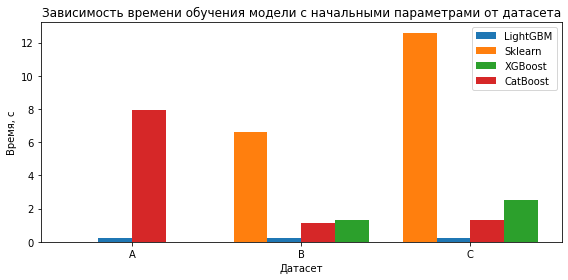

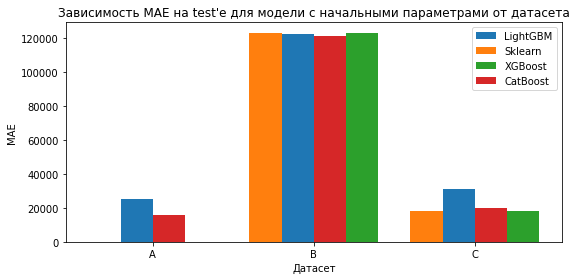

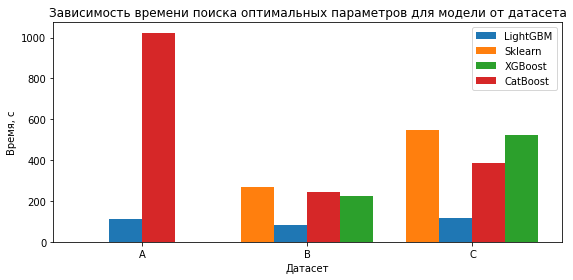

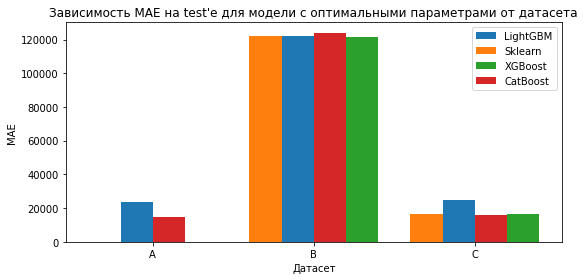

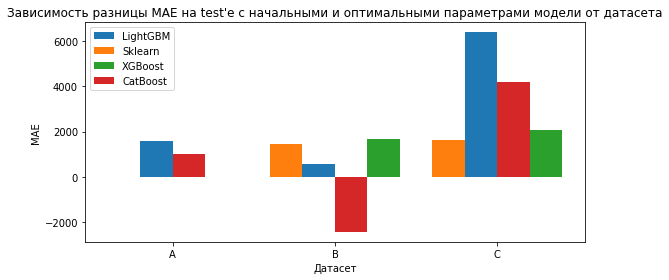

In [8]:
labels = ["A", "B", "C"]
x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize =(8, 4))
ax.set_title("Зависимость времени обучения модели с начальными параметрами от датасета")
ax.bar(x - width/2, df_lgbm[df_lgbm.Parameters == "default"].Time.values, width, label='LightGBM')
ax.bar(x - 3*width/2, df_skl[df_skl.Parameters == "default"].Time.values, width, label='Sklearn')
ax.bar(x + 3*width/2, df_xgb[df_xgb.Parameters == "default"].Time.values, width, label='XGBoost')
ax.bar(x + width/2, df_catb[df_catb.Parameters == "default"].Time.values, width, label='CatBoost')
ax.set_xlabel('Датасет')
ax.set_ylabel('Время, с')
ax.set_xticks(x, labels)
ax.legend()
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize =(8, 4))
ax.set_title("Зависимость MAE на test'е для модели с начальными параметрами от датасета")
ax.bar(x - width/2, df_lgbm[df_lgbm.Parameters == "default"].MAE.values, width, label='LightGBM')
ax.bar(x - 3*width/2, df_skl[df_skl.Parameters == "default"].MAE.values, width, label='Sklearn')
ax.bar(x + 3*width/2, df_xgb[df_xgb.Parameters == "default"].MAE.values, width, label='XGBoost')
ax.bar(x + width/2, df_catb[df_catb.Parameters == "default"].MAE.values, width, label='CatBoost')
ax.set_xlabel('Датасет')
ax.set_ylabel('MAE')
ax.set_xticks(x, labels)
ax.legend()
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize =(8, 4))
ax.set_title("Зависимость времени поиска оптимальных параметров для модели от датасета")
ax.bar(x - width/2, df_lgbm[df_lgbm.Parameters == "best"].Time.values, width, label='LightGBM')
ax.bar(x - 3*width/2, df_skl[df_skl.Parameters == "best"].Time.values, width, label='Sklearn')
ax.bar(x + 3*width/2, df_xgb[df_xgb.Parameters == "best"].Time.values, width, label='XGBoost')
ax.bar(x + width/2, df_catb[df_catb.Parameters == "best"].Time.values, width, label='CatBoost')
ax.set_xlabel('Датасет')
ax.set_ylabel('Время, с')
ax.set_xticks(x, labels)
ax.legend()
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize =(8, 4))
ax.set_title("Зависимость MAE на test'е для модели с оптимальными параметрами от датасета")
ax.bar(x - width/2, df_lgbm[df_lgbm.Parameters == "best"].MAE.values, width, label='LightGBM')
ax.bar(x - 3*width/2, df_skl[df_skl.Parameters == "best"].MAE.values, width, label='Sklearn')
ax.bar(x + 3*width/2, df_xgb[df_xgb.Parameters == "best"].MAE.values, width, label='XGBoost')
ax.bar(x + width/2, df_catb[df_catb.Parameters == "best"].MAE.values, width, label='CatBoost')
ax.set_xlabel('Датасет')
ax.set_ylabel('MAE')
ax.set_xticks(x, labels)
ax.legend()
fig.tight_layout()
plt.show()

delta = [ df_lgbm[df_lgbm.Parameters == "default"].MAE.values - df_lgbm[df_lgbm.Parameters == "best"].MAE.values
        , df_skl[df_skl.Parameters == "default"].MAE.values - df_skl[df_skl.Parameters == "best"].MAE.values
        , df_xgb[df_xgb.Parameters == "default"].MAE.values - df_xgb[df_xgb.Parameters == "best"].MAE.values
        , df_catb[df_catb.Parameters == "default"].MAE.values - df_catb[df_catb.Parameters == "best"].MAE.values
        ]

fig, ax = plt.subplots(figsize =(8, 4))
ax.set_title("Зависимость разницы MAE на test'е с начальными и оптимальными параметрами модели от датасета")
ax.bar(x - width/2, delta[0], width, label='LightGBM')
ax.bar(x - 3*width/2, delta[1], width, label='Sklearn')
ax.bar(x + 3*width/2, delta[2], width, label='XGBoost')
ax.bar(x + width/2, delta[3], width, label='CatBoost')
ax.set_xlabel('Датасет')
ax.set_ylabel('MAE')
ax.set_xticks(x, labels)
ax.legend()
fig.tight_layout()
plt.show()


**Ваши выводы:** Что касается времени обучения, то самой медленной библиотекой, как и заявлялась, является Sklearn. LightGBM работает в разы быстрее с необработанными категориальными признаками, чем CatBoost. Другие 2 библиотеки вообще с ними не работают (пока категории каким-либо образом не закодированы). И вообще, датасет А с категориальными признаками - очень слабое место для Catboost, как уже отмечалось. Также можно сделать вывод, что XGBoost в среднем медленее CatBoost. Первое же место в плане скорости занимает LightGBM. По праву, эту библиотеку справедливо называют самой быстрой. Далее поговорим про качество работы моделей. На датасете В все библиотеки дают примерно одинаковые результаты, но CatBoost при этом, единственный показал себя хуже после кросс-валидации. Хоть ошибка не очень велика, но это звоночек и камень в огород встроенного grid_search и самого алгоритма градиентного бустинга. Если закрыть глаза на ужасно долгое обучение CatBoost на датасете А, то, справедливости ради, с категориальными признаками в чистом виде она работает качественнее, чем LightGBM. Хотя разница в качетстве не так велика, опять-таки в сравнении со временем обучения. Что касается датасета С с закодированными категориальными признаками, то тут все библиотеки показали себя почти одинаково в плане качества (про время мы уже поговорили), но самая быстрая библиотека LightGBM показала заметно худшее качество. Так что, можно сделать предварительный вывод, что, если в задаче нас интересует скорость, то LightGBM отличный вариант, а если качетсво, то стоит посмотреть в сторону CatBoost. А вообще, нужно искать баланс между временем и качеством. И, кажется, в этом плане LightGBM все-таки наиболее подходящий вариант. Кратко отмечу, что вследствие кросс-валидации все модели на всех датасетах дали лучшее качетсво (то есть можно заочно заявить, что делается это не зря, случай с CatBoost будем считать неприятной случайностью). Отдельно отметим, что OHE+CV очень сильно повлияли на качество работы LightGBM в положительную сторону. Чуть менее явно, но то же самое можно сказать и про CatBoost. Во всех остальных случаях мы имеем ожидаемый небольшой прирост в качестве, то есть разницу в МАЕ примерно на несколько тысяч. Итого, хочется сделать вывод, что наиболее продуктивный бустинг представляет библиотека LightGBM.

## Оптимизация параметров с hyperopt

И так, мы с вами научились пользоваться библиотеками для градиентного бустинга. И я почти уверен, что знаю вашу самую "любимую" часть всех этих заданий: оптимизация параметров. Она достаточно долгая, нудная, да еще и над сетками перебора нужно думать. Значит сейчас, когда вы поняли всю тяжесть этого процесса, мы можем узнать как относительно быстро и безболезненно нащупать оптимальные параметры!


[Эмоции выполняющего в этот момент.](https://disk.yandex.ru/i/qwkvBEFrWYoV9A)


Нашего спасителя зовут HyperOpt. На первый взгляд hyperopt делает всё то же самое, что и grid search, а именно перебирает параметры. По факту же hyperopt превращает это в задачу оптимизации, используя некоторые эвристики для ускорения сходимости процесса. К тому же, он требует лишь информацию о границе интарвалов, а не сами сетки. В теории это должно помочь нам добиться лучших результатов за более короткое время. Давайте попробуем это сделать.

Для данного эксперимента я рекомендую использовать lightgbm, поскольку она быстрее и с ней удобнее играться, но Вы можете воспользоваться любой библиотекой из представленных выше.

### Задание 7 (кросс-проверка, 4 балла):
**Данные**: датасет со стоимостью поддержанных автомобилей \
**Метрика**: MAE \
**Цели**: В данном задании следует выполнить следующие пункты:
1. Взять любую библиотеку градиентного бустинга (можете взять самую быструю)
2. Составить сетку перебора в hyperopt, включающую параметры n_estimators, max_depth и learning_rate в hyperopt. Вам могут понадобиться такие типы данных, как hp.choise, hp.qloguniform, hp.uniform и hp.quniform (можно также пользоваться np.arange). Также для округления значения типа float до целых чисел (4.0 -> 4) используйте `scope.int`.
3. Реализуйте функцию, которая принимает на вход словарь параметров для регрессора, и при помощи cv оценивает его качество на датасете A (можно воспользоваться cross_val_score, а для ускорения поставить cv=3). Не забудьте о том, в каком виде lightgbm принимает категориальные признаки в numpy и что также надо передавать индексы категориальных признаков.
4. Создайте объект trials=Trials(), который будет хранить информацию о процессе оптимизации.
5. Используя функцию fmin, оптимизируйте Вашу функцию. Установите algo=tpe.suggest, trials=trials и max_evals, по крайней мере, 50. verbose=1 позволит видеть прогресс-бар по типу tqdm.
6. Выведите получившиеся параметры. Нарисуйте график, показывающий значение loss в ходе оптимизации. Посчитайте качество на тесте при использовании лучших параметров (возвращаются после использования fmin). Сделайте выводы по результату.

100%|██████████████████████████████████████████████| 150/150 [07:50<00:00,  3.14s/trial, best loss: 29993.868679253243]


Hyperopt best parameters:
{'learning_rate': 0.03549950625083899, 'max_depth': 12.0, 'n_estimators': 1000.0}

MAE on test with best parameters: 20025.98189720647



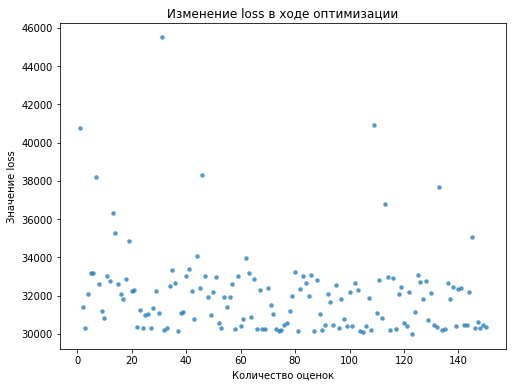

In [9]:
trials = Trials()

def quality(params):
    model = LGBMRegressor(**params)
    metric = -cross_val_score(model, AX_train, Ay_train, cv=3, scoring="neg_mean_absolute_error").mean()
    return {'loss': metric, 'status': STATUS_OK}

grid = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'max_depth': scope.int(hp.quniform('max_depth', 6, 12, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 1000, 5000, 1000))
}

n_evals = 150

best = fmin(fn=quality,
            space=grid,
            algo=tpe.suggest,
            max_evals=n_evals,
            trials=trials,
            verbose=1)

print(f"\n\nHyperopt best parameters:\n{best}\n")

model = LGBMRegressor(learning_rate=best["learning_rate"],
                      max_depth=int(best["max_depth"]),
                      n_estimators=int(best["n_estimators"]))
model.fit(AX_train, Ay_train)
print(f"MAE on test with best parameters: {mean_absolute_error(y_true=Ay_test, y_pred=model.predict(AX_test))}\n")

fig, ax = plt.subplots(figsize=(8, 6))
xs = np.arange(1, n_evals+1, 1)
ys = [t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('Изменение loss в ходе оптимизации')
ax.set_xlabel('Количество оценок')
ax.set_ylabel('Значение loss')
plt.show()

**Ваши выводы:** Сначало отметим, что loss на всем пути обучения попал в некоторую трубку между 30000 и 34000, с небольшим количеством выпапод вверх. То есть, грубо говоря, разницу между истинным значением целевой переменной и предсказанным нашей моделью на всем пути работы hyperopt примерна одинакова: нет какого-то роста или падения, но при этом, эта зависимость все-таки не постоянна. В итоге мы получили оптимальные параметры. После обучения LightGBM с этими параметрами, мы получили лучшее качество на датасете А, чем после кросс-валидации для того же LightGBM. Но, к сожалению, нам не удалось переплюнуть в качестве ужасно долгий CatBoost. Поэтому можно сделать 2 важных вывода. Во-первых, при помощи hyperopt можно получить действительно оптимальные параметры модели, причем за сравнительно небольшое время. А во-вторых, магии не происходит, и если некоторый алгоритм изначально показывает значительно лучшие результаты по отношению к данному, то после нахождения наилучших параметров с помощью hyperopt не стоит ожидать, что наш алгоритм переплюнет тот, что изначально лучше подходит для исходного датасета.

## Предсказание зрительских симпатий

Ну что, детишки, а теперь перейдём к действительно важным вопросам.

**Внимание!** Следующее задание сдается в системе cv-gml.ru, задание `Град. бустинг (ML)` Для выполнения этого задания необходимо скачать датасет из задания. Здесь вы можете немного почитать про датасет и, при желании, поэкспериментировать. На cv-gml.ru загружайте уже готовый скрипт с подобранными параметрами для обучаемого регрессора. Релизовать код необходимо в шаблонном файле awards_prediction.py, который вы можете найти в проверяющей системе.

В некотором царстве, некотором государстве была развита кинопромышленность. Новые фильмы в этом государстве показывают по интернету, а пользователи после просмотра могут дать фильму некоторую "награду". Наша цель - предсказать число наград для фильма.

В нашем распоряжении имеются следующие данные:

**awards** - количество наград, полученных фильмом от пользователей (целевое значение)  
**potions** - количество магических зелий, потраченных на создание спец-эффектов  
**genres** - жанры созданного фильма  
**questions** - количество вопросов, заданных пользователями на соответствующих форумах об этом фильме до премьеры  
**directors** - режиссеры фильма (если неизвестны, то unknown)  
**filming_locations** - области, в которых снимался фильм  
**runtime** - продолжительность фильма в некоторых единицах, принятых в этом государстве  
**critics_liked** - количество критиков из 100, присудивших награды фильму на предварительных закрытых показах  
**pre-orders** - количество зрителей, заранее купивших билеты на первый показ  
**keywords** - ключевые слова, описывающие содержание фильма
**release_year** - год, во котором фильм был показан (конечно, в летоисчислении этого государства)

Следующие поля появляются несколько раз с разными значениями i:

**actor_i_known_movies** - количество известных фильмов актера i (i от 1 до 3)

**actor_i_postogramm** - количество подписчиков в социальной сети "по сто грамм" актера i (i от 1 до 3)

**actor_i_gender** - пол актера i (i от 1 до 3)

**actor_i_age** - возраст актера i (i от 1 до 3)

-----
**Внимание!** Учтите, что при OHE кодировании признаки на обучении и тестировании должны совпадать! Если вы примените простое .get_dummies() или что-то подобное, то признаки на трейне и тесте получатся разные! Так что вам, вероятно, придётся придумать способ для того, чтобы сохранить их :)  

### Задание 8 (ML задание, 20 баллов):
**Данные**: датасет с ценами поддержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Взять любую библиотеку градиентного бустинга
2. Используя предложенный датасет, обучить регрессор для предсказания awards (предоставляем полную свободу в настройках и выборе методов)
3. Загрузить решение и получить качество на закрытой выборке больше порогового значения

In [10]:
## your efficient code here


## Конец

Ну что детишки... Можете добавлять еще 4 библиотеки в своё резюме датасаентиста!
